# Model 4

## Model Overview

Model 4 is a model using multi-attention head layers to try to use attention instead of LSTM layers. The model basically encompasses only the Encoder block of a transformer model, due to the language generation model using a y that is the next word.

This is different from a model that would need to pay attention to the structure of the y as well, such as a question and answer model, or a translator model.

This model is trained on the entire Data Set.

## Installations and Imports

In [ ]:
!pip install -U tensorflow-text

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import io
import os
import unicodedata

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.data.experimental import AUTOTUNE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import collections
import logging
import os
import pathlib
import string
import sys

import tensorflow_text as text
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)

2.6.0


Unlike the other models, this model requires Tensorflow 2.6, which is not supported in the usual way as an installation to Anaconda. Hence, a check has to be done in order to ensure that the model will run.

### Importing on Google Colabs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_name = '/content/drive/MyDrive/DSI24/wine_df_cleaned.csv'

In [ ]:
test_table = pd.read_csv('/content/drive/MyDrive/DSI24/test_table.csv')
wine_df = pd.read_csv(path_name)
wine_notes = [note for note in wine_df['wine_notes']]

### Importing from hard drive

In [ ]:
# path_name = 'wine_df_cleaned.csv'

In [ ]:
# wine_df = pd.read_csv(path_name)
# test_table = pd.read_csv('test_table.csv')

## Preprocessing Data

In [ ]:
class WinenoteDataset:
    def __init__(self):
        self.wine_tokenizer = None

    def preprocess_sentence(self, w):
        w = w + ' <end>'
        return w

    def create_dataset(self, path, num_examples):
        # path : path to wine_notes.txt file
        # num_examples : Limit the total number of training example for faster training 
        # (set num_examples = len(lines) to use full data)
        wine_df = pd.read_csv(path)
        wine_notes = [self.preprocess_sentence(note) for note in wine_df['wine_notes'][:num_examples]]
        return wine_notes

    def tokenize(self, notes):
        tokenizer = Tokenizer()
        
        # Create word index
        tokenizer.fit_on_texts(notes)    
        tensor = tokenizer.texts_to_sequences(notes)
        
        # Pad sequences
        padded_tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=75, padding='pre')

        return padded_tensor, tokenizer

    def load_dataset(self, path, num_examples=None):
        wine_notes = self.create_dataset(path, num_examples)
        wine_notes, self.wine_tokenizer = self.tokenize(wine_notes)

        return wine_notes, self.wine_tokenizer
    
    def call(self, num_examples, batch_size):
        tensor, self.wine_tokenizer = self.load_dataset(path_name, num_examples)
        tensor = tf.convert_to_tensor(tensor, dtype=tf.int64)
        wine_dataset = tf.data.Dataset.from_tensor_slices(tensor)
        wine_dataset = wine_dataset.batch(
            batch_size, drop_remainder = True, num_parallel_calls = AUTOTUNE
                                         ).prefetch(AUTOTUNE)
        
        return wine_dataset, self.wine_tokenizer

In [ ]:
batch_size = 8192
num_examples = len(wine_df) # full dataset
# To limit the training examples for faster training or for testing
# batch_size = 128
# num_examples = 1000 

dataset_creator = WinenoteDataset()
wine_dataset, wine_tokenizer = dataset_creator.call(num_examples, batch_size)

## Custom Layers and Functions therein

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, drop_rate = 0.1):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim 
        self.drop_rate = drop_rate
        self.maxlen = maxlen
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        '''Embedding a word meaning and a position vector onto the inputs
        '''
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """Mask the upper half of the dot product matrix in self attention.
    Masks future tokens and prevents predictions based on future tokens.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)

In [ ]:
#Encoder Layer

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), 
             layers.Dense(embed_dim),]
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, mask):
        '''Creating the encoder layer. Each layer consists of:
        Multihead Attention layer
        Dropout layer
        Normalisation layer
        Feed Forward layer (Dense 'Relu' + Dense)
        Dropout layer
        Normalisation layer
        '''
        
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [ ]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, num_layers, rate=0.1):

        super(EncoderBlock, self).__init__()

        self.num_layers = num_layers

        self.enc_layers = [EncoderLayer(embed_dim, num_heads, ff_dim, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x):
        '''
        Creates the encoder block:
        1. Receives input from the Token and Embedding layer
        2. Masks input
        3. Creates num_layers of encoding layers
        '''
        
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, causal_mask)

        return x  # (batch_size, input_seq_len, embed_dim)

## Model Creation

### Model Settings

In [ ]:
vocab_size = len(wine_tokenizer.index_word) + 1
maxlen = 74  # Max sequence size
embed_dim = 1500  # Embedding size for each token
num_heads = 8  # Number of attention heads
feed_forward_dim = 1500  # Hidden layer size in feed forward network inside transformer
num_layers = 4 # Number of Attention Layers
dropout_rate = 0.1

### Model

In [ ]:
def split_input_target(sequence):
    '''Splits the data as is streams out into Xs and Ys:
    X - Words until the word to be predicted
    Y - Word to be predicted
    '''
    inp = sequence[:, :-1]
    tar = sequence[:, 1:]
    return inp, tar

In [ ]:
def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
    
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim, dropout_rate)
    x = embedding_layer(inputs)
    
    Encoder_Block = EncoderBlock(embed_dim, num_heads, feed_forward_dim, num_layers, dropout_rate)
    x = Encoder_Block(x)
    
    outputs = layers.Dense(vocab_size)(x)
    
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        "adam", loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 74)]              0         
_________________________________________________________________
token_and_position_embedding (None, 74, 1500)          37884000  
_________________________________________________________________
encoder_block_9 (EncoderBloc (None, 74, 1500)          306186000 
_________________________________________________________________
dense_59 (Dense)             (None, 74, 25182)         37798182  
Total params: 381,868,182
Trainable params: 381,868,182
Non-trainable params: 0
_________________________________________________________________


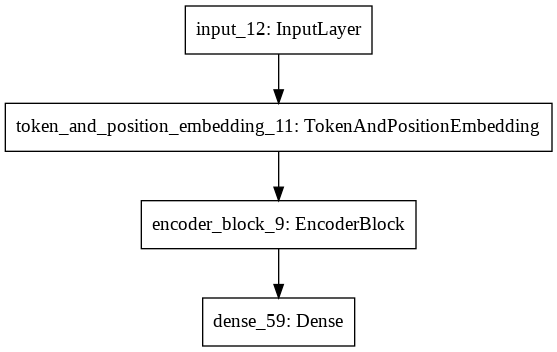

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
n_epochs = 20

for epoch in range(n_epochs):
    start = time.time()
    print(f'Epoch {epoch + 1} starting...')
    for (batch, tensor) in enumerate(wine_dataset):
        inp, tar = split_input_target(tensor)
        print(f'Batch {batch + 1} starting...')
        model.fit(inp, tar)

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 starting...
Batch 1 starting...
256/256 [==============================] - 320s 1s/step - loss: 5.5363 - dense_59_loss: 5.5363
Batch 2 starting...
256/256 [==============================] - 320s 1s/step - loss: 5.5258 - dense_59_loss: 5.5258
Batch 3 starting...
256/256 [==============================] - 320s 1s/step - loss: 5.2765 - dense_59_loss: 5.2765
Batch 4 starting...
256/256 [==============================] - 320s 1s/step - loss: 5.1990 - dense_59_loss: 5.1990
Batch 5 starting...
256/256 [==============================] - 320s 1s/step - loss: 5.1680 - dense_59_loss: 5.1680
Time taken for 1 epoch: 1607.87 secs

Epoch 2 starting...
Batch 1 starting...
256/256 [==============================] - 320s 1s/step - loss: 5.4853 - dense_59_loss: 5.4853
Batch 2 starting...
256/256 [==============================] - 320s 1s/step - loss: 5.4941 - dense_59_loss: 5.4941
Batch 3 starting...
256/256 [==============================] - 320s 1s/step - loss: 5.2561 - dense_59_loss: 5.2561
Ba

## Text Generation

### Text Generation Functions

In [ ]:
def top_k_sample(logits, top_k = 50):
    '''Custom Top_k sampler
    '''
    logits, indices = tf.math.top_k(logits, k=top_k, sorted=True)
    indices = np.asarray(indices).astype("int32")
    preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
    preds = np.asarray(preds).astype("float32")
    return np.random.choice(indices, p=preds)

def text_generation(seed_text, top_k = 50):
    '''Text generator based on the above model.
    Requires a seed_text to begin predictions.
    '''
    token_list = wine_tokenizer.texts_to_sequences([seed_text])[0] # Tokenizing seed text
    num_tokens_generated = 0
    tokens_generated = []
    while num_tokens_generated <= (maxlen + 1 - len(token_list)):  # Limit sentence len to 75
        pad_len = maxlen + 1 - len(token_list)
        sample_index = len(token_list) - 1
        if pad_len < 0:
            # Check is seed text is too long
            x = token_list[:maxlen]
            sample_index = maxlen - 1
        elif pad_len > 0:
            # Pad seed text for predictions
            x = token_list + [0] * pad_len
        else:
            # if seed text is = to max length
            x = token_list
        x = np.array([x])
        y, _ = model.predict(x[0])
        sample_token = top_k_sample(y[sample_index].flatten(), top_k)
        token_list.append(sample_token)
        num_tokens_generated = len(token_list)
    txt = wine_tokenizer.sequences_to_texts([token_list])
    return txt

In [ ]:
def fetch_random_seq():
    '''Creates a random number, and then fetches a random starting sequence 
    based on that number from our original dataset, as well as the rest of
    the tasting note
    '''
    value = random_num_pick()
    start_seq = test_table['start_seq'][value].values[0]
    end_seq = end_seq = test_table['end_seq'][value].values[0]
    return start_seq, end_seq

def random_num_pick():
    return np.random.randint(len(test_table), size = 1)

In [ ]:
start_seq, end_seq = fetch_random_seq()
generated_seq = text_generation(start_seq)
print(f'Random starting sequence: {start_seq}')
print(f'Generated  sequence: {generated_seq}')
print('-----------------')
print(f'Ground truth: {end_seq}')

Random starting sequence: (made from 40% syrah, 40% grenache and 20% cinsault): Light orange. Aromas of dried cherry
Generated  sequence: ['made from 40 syrah 40 grenache and 20 cinsault light orange aromas of dried cherry fruit of but the the and and good 2011 ruby sweet with end cherry long']
-----------------
Ground truth: and rose are lifted and sharpened by a note of white pepper and pick up a floral quality with aeration. Fleshy, focused and dry, offering bitter orange pith and red fruit flavors and a hint of anise that builds with air. Closes with good energy and thrust, leaving subtle floral and mineral notes behind.


In [ ]:
wine_note_1 = text_generation('Aromatic and beautiful')
wine_note_1

['aromatic and beautiful but the the the on good the and finishes dark and nose of a berry of offering with a to an by this palate']

In [ ]:
wine_note_2 = text_generation('Lush')
wine_note_2

['lush in wine bright licorice end and offering aromas bright of this the flavors and notes by end finishes flavors the']

In [ ]:
wine_note_3 = text_generation('Red Wine')
wine_note_3

['red wine the with that is of finishes flavors sweet in on the']

In [ ]:
wine_note_4 = text_generation('Wine')
wine_note_4

['wine that licorice and and for end and and with offering but tannins in 2011 and']

In [ ]:
wine_note_5 = text_generation('Keyboard')
wine_note_5

['and is but and tannins a is and good palate a an sweet a very the and red tannins and of with']

In [ ]:
wine_note_6 = text_generation('Bukit Pasoh')
wine_note_6

['is and on bright end berry the with of a of and that of and aromas by']

In [ ]:
def fetch_seq(value):
    return test_table['start_seq'][value].values[0]

def random_num_pick():
    return np.random.randint(len(test_table), size = 1)

def random_text_generator():
    pick_value = random_num_pick()
    start_seq = fetch_seq(pick_value)

    x = text_generation(start_seq)

    end_seq = test_table['end_seq'][pick_value].values[0]

    print(f'Starter seed: "{start_seq}"')
    print('-----------------------------')
    print(f'Generated text: "{x}"')
    print(f'Original tasting note end sequence: {end_seq}')

In [ ]:
random_text_generator()

Starter seed: "The 2020 Château des Places has a pure but slightly one-dimensional nose of black cherries"
-----------------------------
Generated text: "['the 2020 château des places has a pure but slightly one dimensional nose of black cherries sweet finish fruit aromas and and']"
Original tasting note end sequence: and blueberry. The palate is ripe and candied, but again, it lacks complexity and personality. All sweetness, but not enough to counterbalance it.


In [ ]:
random_text_generator()

Starter seed: "The 2013 Cabernet Sauvignon Lewelling Ranch is bright, focused and nuanced, with striking aromatics and"
-----------------------------
Generated text: "['the 2013 cabernet sauvignon lewelling ranch is bright focused and nuanced with striking aromatics and and of good with flavors and floral the very this']"
Original tasting note end sequence: quite a bit of complexity. Understated and classy, with attractive freshness and tons of finesse, the Lewelling Ranch shows the more polished style of the year. Even so, there is plenty of underlying tannic grip.


In [ ]:
random_text_generator()

Starter seed: "Deep purple. Cassis and violet on the nose, along with hints of cocoa torrefaction and"
-----------------------------
Generated text: "['deep purple cassis and violet on the nose along with hints of cocoa torrefaction and and to and with flowers and in bright good finish']"
Original tasting note end sequence: herbs. Sounds acidity lifts the flavors of blackberry syrup, coffee and cocoa, but mounting astringent tannins take over on the moderately persistent finish.
